Load 'sign' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_sign.csv
Load 'label' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_label.csv
Load 'tile' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_tile.csv
Loading & preparing image data...

Cropping & loading labels by 1st image:
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_07_mon_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Crop labels is done.

Resizing images by 1st label:
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_07_mon_comp.b.tif
Files was

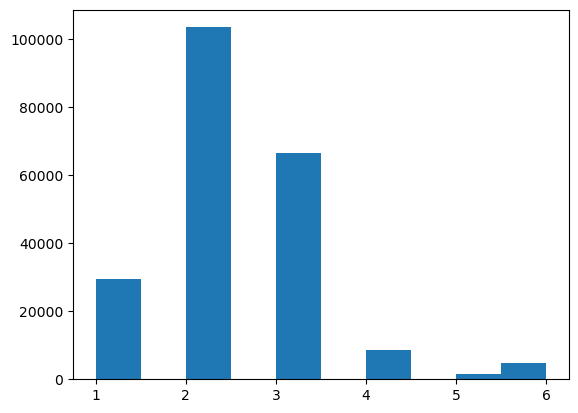

In [17]:
from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *

downgrade_labels = False
force = False

if downgrade_labels:
    src = DEFAULT_PATH["labels"]
    out = DEFAULT_PATH["labels"] + "downgraded/"
    classes_matching = DEFAULT_PATH["labels"] + "classes_matching.csv"
    downgrade_classes(src, out, classes_matching)
    DEFAULT_PATH["labels"] = out

# you can use force=True for re-write all caches.
signs = parse_tifs_from(DEFAULT_PATH["images"], "sign", force=force)
signs = signs.query("type == 'sign'")

labels = parse_tifs_from(DEFAULT_PATH["labels"], "label", force=force)
labels = labels.query("type == 'label'")

year = 2020
only_bands = ["r", "b", "g", "n"]
mask_mode = "homogeneous"
stratify = False
resize = "by_label"
r = 1
homogen_percent = 0.2
percent_assign = 1

signs_paths = (
    signs.query(f"year == {year} and season == 'mon' and band in @only_bands")
    .sort_values("month")
    .sort_values("band")
)
labels_paths = labels.query(f"year == {year}")


# for 10m low RAM load
only_bands = ["r", "b", "g", "n"]
tiles = DEFAULT_PATH["images"] + "tiles/"
tiles = parse_tifs_from(tiles, typeof="tile", force=force)
tiles = tiles.query("band in @only_bands").sort_values("month").sort_values("band")
# signs_paths = tiles


z_x, z_y, x, y = generate_dataset(
    signs_paths,
    labels_paths,
    percent_assign,
    mask_mode=mask_mode,
    resize=resize,
    r=r,
    stratify=stratify,
    homogen_percent=homogen_percent,
    force=force,
    verbose=True,
    save_mask=True,
)

uniq_type, uniq_count = np.unique(z_y, return_counts=True)
print(uniq_type, uniq_count)
plt.hist(z_y)
plt.show()

Split X, y -> X_train, y_train...
Start training model...
Selected model / method: RF
Model was trained. Start validate it...

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.87      0.84       995
           2       0.64      0.71      0.67      1012
           3       0.52      0.56      0.54       950
           4       0.96      0.95      0.95       951
           5       0.70      0.77      0.74       987
           6       0.46      0.28      0.35       937

    accuracy                           0.69      5832
   macro avg       0.68      0.69      0.68      5832
weighted avg       0.68      0.69      0.68      5832

Confusion Matrix:
[[870   8  63   5  38  11]
 [ 18 717 120   4  35 118]
 [ 77 140 528   2  90 113]
 [ 20   5  12 902   5   7]
 [ 47  31  78   6 762  63]
 [ 54 221 218  24 153 267]]
Saving model...
Model was saved: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/tmp_weights_RF.joblib


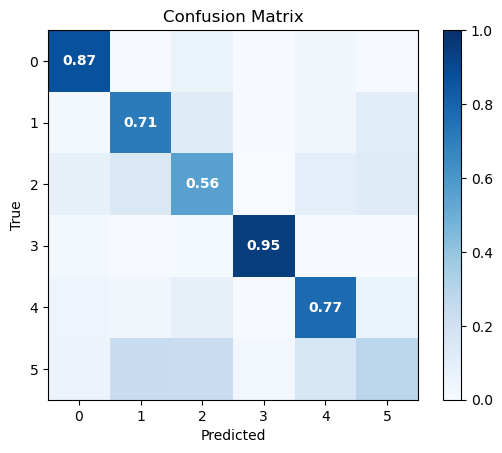

In [2]:
m, m_rep, m_cm, f1 = train_model(z_x, z_y)
plot_confusion(m_cm)

In [3]:
# Mapping by loaded images from path (10m)
# force = False

only_bands = ["r", "b", "g", "n"]
tiles = DEFAULT_PATH["images"] + "tiles/"
tiles = parse_tifs_from(tiles, typeof="tile", force=force)
tiles = (
    tiles.query("band in @only_bands").sort_values("month").sort_values("band")["path"]
)
tiles = tiles.to_list()

loaded_tiles = []
for t in tiles:
    loaded_tiles.append(load_tif(t, only_first=True))

out = f"handle_10m_{mask_mode}_stratify_{stratify}_f1_{f1:.2f}.tif"
out = DEFAULT_PATH["output"] + out
predicted = create_map(loaded_tiles, m, out)

Parsed 8 tifs of type 'tile' and saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_tile.csv
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/39UVV/2020_06_01/comp_s2_90d_b2_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/39UVV/2020_09_01/comp_s2_90d_b2_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/39UVV/2020_06_01/comp_s2_90d_b3_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/39UVV/2020_09_01/comp_s2_90d_b3_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/39UVV/2020_06_01/comp_s2_90d_b8_l2a_med.frag.0

Creating map...: 100%|██████████| 58/58 [03:35<00:00,  3.71s/it]


Map is done.
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_secure_stratify_True_f1_0.68.tif


Load 'etalon' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_etalon.csv
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_secure_stratify_True_f1_0.80.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_secure_stratify_True_f1_0.80.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
(10980, 10980)
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/positive_handle_10m_secure_stratify_True_f1_0.80.tif
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_sec

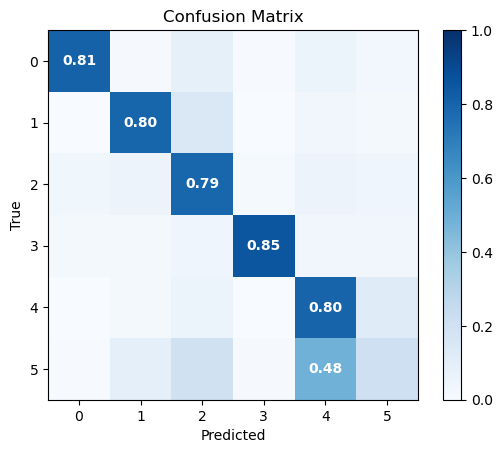

In [1]:
# Module: validation
from validation import *
from visualisation import *

year = 2020
map = "wc"
force = False

predicted = "/Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_10m_secure_stratify_True_f1_0.80.tif"
etalons = DEFAULT_PATH["etalons"]
etalons = parse_tifs_from(etalons, typeof="etalon", force=force)
# etalons = etalons.query(f"year == '{year}' and map =='{map}'")["path"].to_list()
etalons = etalons.query(f"year == {year} and map =='{map}'")["path"].to_list()
r = validate_how_tif(predicted, etalons, force=force)
create_diff_map(predicted, etalons, "positive")
create_diff_map(predicted, etalons, "negative")

plot_confusion(r["r36000.2020.wc.cor.tif"]["cf_matrix"])
print(r["r36000.2020.wc.cor.tif"]["report"])

In [19]:
etalons

['/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/etalons/r36000.2020.wc.cor.tif']

In [ ]:
# for 10m low RAM load
# automate create of maps

from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *
from tqdm import tqdm

downgrade_labels = False
force = False
if downgrade_labels:
    src = DEFAULT_PATH["labels"]
    out = DEFAULT_PATH["labels"] + "downgraded/"
    classes_matching = DEFAULT_PATH["labels"] + "classes_matching.csv"
    downgrade_classes(src, out, classes_matching)
    DEFAULT_PATH["labels"] = out

# you can use force=True for re-write all caches.
# signs = parse_tifs_from(DEFAULT_PATH["images"], "sign", force=force)
# signs = signs.query("type == 'sign'")
# signs_paths = (
#     signs.query(f"year == {year} and season == 'mon' and band in @only_bands")
#     .sort_values("month")
#     .sort_values("band")
# )

# Base settings for all settings.
year = 2020
map = "wc"
force = False
verbose = False
etalons = DEFAULT_PATH["etalons"]
etalons = parse_tifs_from(etalons, typeof="etalon", force=True)
etalons = etalons.query(f"year == '{year}' and map =='{map}'")["path"].to_list()

only_bands = ["r", "b", "g", "n"]
tiles = DEFAULT_PATH["images"] + "tiles/"
tiles = parse_tifs_from(tiles, typeof="tile", force=True)
tiles = tiles.query("band in @only_bands").sort_values("month").sort_values("band")
signs_paths = tiles
tiles = tiles["path"].to_list()
loaded_tiles = []
for t in tiles:
    loaded_tiles.append(load_tif(t, only_first=True))

labels = parse_tifs_from(DEFAULT_PATH["labels"], "label", force=True)
labels = labels.query("type == 'label'")
labels_paths = labels.query(f"year == {year}")
# end base settings


# Parameter sets to cycle through
settings = [
    {
        "mask_mode": "random",
        "stratify": True,
        "resize": "by_sign",
        "r": 1,
        "homogen_percent": 1,
        "percent_assign": 0.001,
    },
    {
        "mask_mode": "random",
        "stratify": False,
        "resize": "by_sign",
        "r": 1,
        "homogen_percent": 1,
        "percent_assign": 0.0001,
    },
    {
        "mask_mode": "secure",
        "stratify": True,
        "resize": "by_sign",
        "r": 50,
        "homogen_percent": 1,
        "percent_assign": 0.1,
    },
    {
        "mask_mode": "secure",
        "stratify": True,
        "resize": "by_sign",
        "r": 90,
        "homogen_percent": 1,
        "percent_assign": 0.1,
    },
    {
        "mask_mode": "secure",
        "stratify": False,
        "resize": "by_sign",
        "r": 20,
        "homogen_percent": 1,
        "percent_assign": 0.0001,
    },
    {
        "mask_mode": "homogeneous",
        "stratify": True,
        "resize": "by_sign",
        "r": 1,
        "homogen_percent": 0.01,
        "percent_assign": 1,
    },
    {
        "mask_mode": "homogeneous",
        "stratify": False,
        "resize": "by_sign",
        "r": 1,
        "homogen_percent": 0.1,
        "percent_assign": 0.01,
    },
]

res = {}

for s in tqdm(settings, desc="Parameter sets"):
    mask_mode = s["mask_mode"]
    stratify = s["stratify"]
    resize = s["resize"]
    r = s["r"]
    homogen_percent = s["homogen_percent"]
    percent_assign = s["percent_assign"]

    z_x, z_y, x, y = generate_dataset(
        signs_paths,
        labels_paths,
        percent_assign,
        mask_mode=mask_mode,
        resize=resize,
        r=r,
        stratify=stratify,
        homogen_percent=homogen_percent,
        force=force,
        verbose=verbose,
    )

    uniq_type, uniq_count = np.unique(z_y, return_counts=True)
    print(
        f"mask_mode={mask_mode}, stratify={stratify}, resize={resize}, r={r}, homogen_percent={homogen_percent}, percent_assign={percent_assign}"
    )
    print(uniq_type, uniq_count)
    plt.hist(z_y)
    plt.show()

    m, m_rep, m_cm, f1 = train_model(z_x, z_y)
    plot_confusion(m_cm)

    resize_out = "10m" if resize == "by_sign" else "230m"
    out = f"auto_{resize_out}_{mask_mode}_stratify_{stratify}_f1_{f1:.2f}.tif"
    out = DEFAULT_PATH["output"] + out
    predicted = create_map(loaded_tiles, m, out)

    print("Validate it...")
    r_val = validate_how_tif(predicted, etalons, force=force)

    # Store results for later analysis
    res_key = (
        f"{mask_mode}_stratify_{stratify}_{resize}_{homogen_percent}_{percent_assign}%"
    )
    res[res_key] = {
        "cf_matrix": r_val["r36000.2020.wc.cor.tif"]["cf_matrix"],
        "report": r_val["r36000.2020.wc.cor.tif"]["report"],
        "f1": f1,
        "model": m,
        "out_path": out,
    }

    plot_confusion(r_val["r36000.2020.wc.cor.tif"]["cf_matrix"])
    print(r_val["r36000.2020.wc.cor.tif"]["report"])


In [ ]:
etalons = DEFAULT_PATH["etalons"]
etalons = parse_tifs_from(etalons, typeof="etalon", force=True)
etalons = etalons.query(f"year == {year} and map =='{map}'")["path"].to_list()
etalons

Parsed 2 tifs of type 'etalon' and saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_etalon.csv


[]

Load 'etalon' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_etalon.csv
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_homogeneous_stratify_False_f1_0.54.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
              precision    recall  f1-score   support

           1       0.94      0.79      0.86  28111766
           2       0.77      0.68      0.72  44659932
           3       0.54      0.79      0.64  28722345
           4       0.99      0.71      0.83   3589496
           5       0.00      0.00      0.00   2239886
           6       0.01      0.00      0.00    808218

    accuracy                           0.72 108131643
   macro avg       0.54      0.50      0.51 108131643
weighted avg       0.74      0.72      0.72 108131643



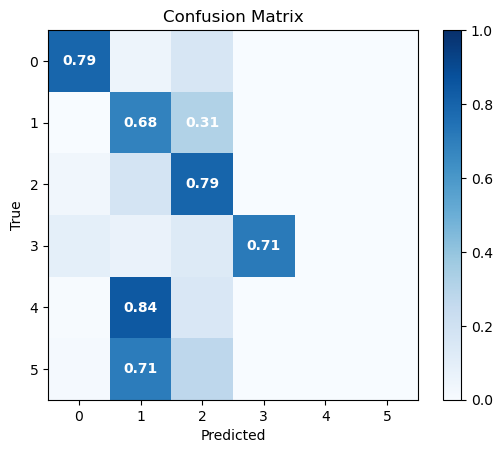

In [6]:
# Module: validation
from validation import *
from visualisation import *
from tqdm import tqdm

year = 2020
map = "wc"
force = False

etalons = DEFAULT_PATH["etalons"]
etalons = parse_tifs_from(etalons, typeof="etalon", force=force)
# etalons = etalons.query(f"year == '{year}' and map =='{map}'")["path"].to_list()
etalons = etalons.query(f"year == {year} and map =='{map}'")["path"].to_list()

preds = [
    "/Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_homogeneous_stratify_False_f1_0.54.tif",
    "/Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_homogeneous_stratify_True_f1_0.78.tif",
    "/Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_random_stratify_False_f1_0.48.tif",
    "/Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_random_stratify_True_f1_0.54.tif",
    "/Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_secure_stratify_False_f1_0.63.tif",
    "/Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_secure_stratify_True_f1_0.85.tif",
]

# for pred in tqdm(preds, desc="Validate of serious predictions"):
r = validate_how_tif(preds[0], etalons, force=force)
plot_confusion(r["r36000.2020.wc.cor.tif"]["cf_matrix"])
print(r["r36000.2020.wc.cor.tif"]["report"])

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_homogeneous_stratify_True_f1_0.78.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
              precision    recall  f1-score   support

           1       0.94      0.73      0.82  28111766
           2       0.88      0.41      0.56  44659932
           3       0.43      0.90      0.58  28722345
           4       0.96      0.78      0.86   3589496
           5       0.01      0.00      0.00   2239886
           6       0.01      0.01      0.01    808218

    accuracy                           0.63 108131643
   macro avg       0.54      0.47      0.47 108131643
weighted avg       0.76      0.63      0.63 108131643



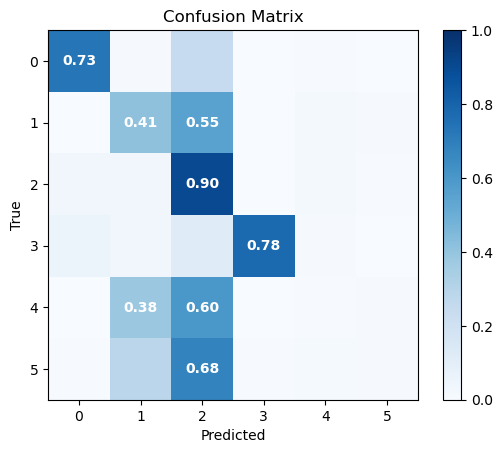

In [7]:
r = validate_how_tif(preds[1], etalons, force=force)
plot_confusion(r["r36000.2020.wc.cor.tif"]["cf_matrix"])
print(r["r36000.2020.wc.cor.tif"]["report"])

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_random_stratify_False_f1_0.48.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
              precision    recall  f1-score   support

           1       0.96      0.70      0.81  28111766
           2       0.86      0.64      0.73  44659932
           3       0.51      0.92      0.66  28722345
           4       0.96      0.73      0.83   3589496
           5       0.01      0.00      0.00   2239886
           6       0.00      0.00      0.00    808218

    accuracy                           0.71 108131643
   macro avg       0.55      0.50      0.50 108131643
weighted avg       0.77      0.71      0.71 108131643



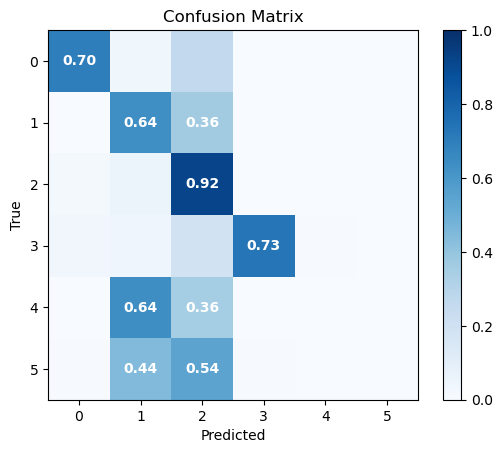

In [8]:
r = validate_how_tif(preds[2], etalons, force=force)
plot_confusion(r["r36000.2020.wc.cor.tif"]["cf_matrix"])
print(r["r36000.2020.wc.cor.tif"]["report"])

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_random_stratify_True_f1_0.54.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
              precision    recall  f1-score   support

           1       0.93      0.80      0.86  28111766
           2       0.92      0.68      0.78  44659932
           3       0.69      0.66      0.68  28722345
           4       0.54      0.85      0.66   3589496
           5       0.24      0.77      0.37   2239886
           6       0.02      0.28      0.04    808218

    accuracy                           0.71 108131643
   macro avg       0.56      0.67      0.56 108131643
weighted avg       0.83      0.71      0.76 108131643



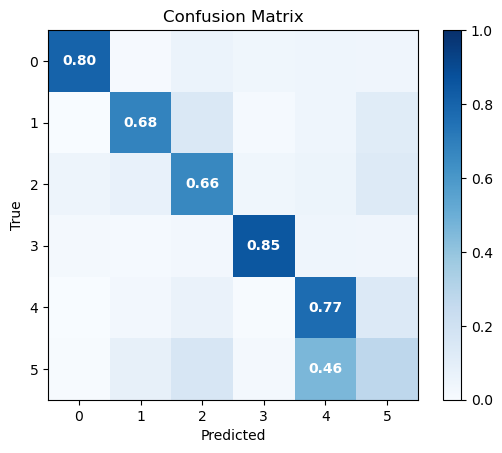

In [9]:
r = validate_how_tif(preds[3], etalons, force=force)
plot_confusion(r["r36000.2020.wc.cor.tif"]["cf_matrix"])
print(r["r36000.2020.wc.cor.tif"]["report"])

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_secure_stratify_False_f1_0.63.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.


/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

           1       0.95      0.75      0.84  28111766
           2       0.84      0.72      0.77  44659932
           3       0.56      0.85      0.67  28722345
           4       0.96      0.75      0.84   3589496
           5       0.00      0.00      0.00   2239886
           6       0.00      0.00      0.00    808218

    accuracy                           0.74 108131643
   macro avg       0.55      0.51      0.52 108131643
weighted avg       0.77      0.74      0.75 108131643



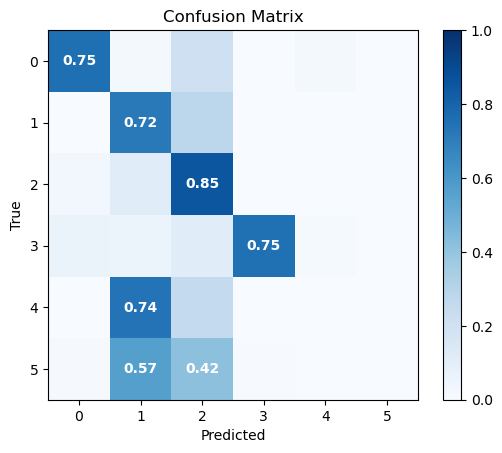

In [10]:
r = validate_how_tif(preds[4], etalons, force=force)
plot_confusion(r["r36000.2020.wc.cor.tif"]["cf_matrix"])
print(r["r36000.2020.wc.cor.tif"]["report"])

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/output/auto_10m_secure_stratify_True_f1_0.85.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
              precision    recall  f1-score   support

           1       0.96      0.75      0.84  28111766
           2       0.89      0.59      0.71  44659932
           3       0.58      0.79      0.67  28722345
           4       0.85      0.83      0.84   3589496
           5       0.06      0.36      0.11   2239886
           6       0.20      0.06      0.09    808218

    accuracy                           0.68 108131643
   macro avg       0.59      0.56      0.54 108131643
weighted avg       0.80      0.68      0.72 108131643



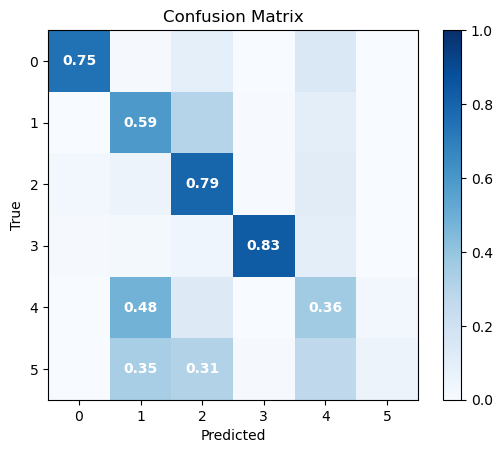

In [11]:
r = validate_how_tif(preds[5], etalons, force=force)
plot_confusion(r["r36000.2020.wc.cor.tif"]["cf_matrix"])
print(r["r36000.2020.wc.cor.tif"]["report"])